In [132]:
!pip install yahoo_fin
from yahoo_fin.stock_info import get_data
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
from sklearn.svm import SVR
from matplotlib import pyplot as plt
import datetime


stock_name = "aapl"
begin_date = "04/30/21"
# end_date = "05/28/2022"
year = 365

date_1 = datetime.datetime.strptime(begin_date, "%m/%d/%y")
end_date = date_1 + datetime.timedelta(days=year*2)

stock = get_data(stock_name, start_date=begin_date, end_date=f'{end_date.month}/{end_date.day}/{end_date.year}', index_as_date = True, interval="1d")
stock.dropna(inplace=True)
stock = stock.to_numpy()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [133]:
scaler = MinMaxScaler(feature_range=(0,1))

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)


close_prices = stock[:,4]

train_size = int(close_prices.shape[0] * 0.8)
train_data = scaler.fit_transform(close_prices[:train_size].reshape(-1, 1))
test_data = scaler.fit_transform(close_prices[train_size:].reshape(-1, 1))


time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [134]:
from sklearn.model_selection import GridSearchCV

params = {'kernel': ("linear", 'rbf', 'sigmoid'), "C": (1e2, 102, 105), "gamma": ("scale", "auto")}
grid = GridSearchCV(SVR(), params)
grid.fit(X_train, y_train)
print(grid.best_params_)

{'C': 100.0, 'gamma': 'scale', 'kernel': 'linear'}


0.9568568567412138


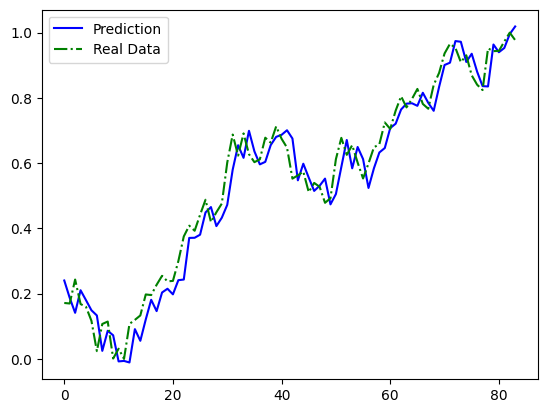

In [135]:
svr = SVR(kernel=grid.best_params_["kernel"], C=grid.best_params_["C"], gamma=grid.best_params_["gamma"]).fit(X_train, y_train)
print(svr.score(X_test, y_test))

pred = svr.predict(X_test)
x = [i for i in range(pred.shape[0])]
plt.plot(x, pred, "b")
plt.plot(x, y_test, "g-.")
plt.legend(["Prediction", "Real Data"])
plt.show()

In [136]:
def predict(pred_days, model):
  x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
  temp_input=list(x_input)
  temp_input=temp_input[0].tolist()


  lst_output=[]
  n_steps=time_step
  # pred_days = 10
  for i in range(pred_days):    
      if(len(temp_input)>time_step):
          
          x_input=np.array(temp_input[1:])
          x_input=x_input.reshape(1,-1)
          
          yhat = model.predict(x_input)
          temp_input.extend(yhat.tolist())
          temp_input=temp_input[1:]
        
          lst_output.extend(yhat.tolist())
          
      else:
          yhat = svr.predict(x_input)
          
          temp_input.extend(yhat.tolist())
          lst_output.extend(yhat.tolist())
          

  last_days=np.arange(1,time_step+1)
  day_pred=np.arange(time_step+1,time_step+pred_days+1)
  return last_days, day_pred, lst_output

/usr/local/lib/python3.9/dist-packages/yahoo_fin/stock_info.py:29: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  end_seconds = int(pd.Timestamp(end_date).timestamp())


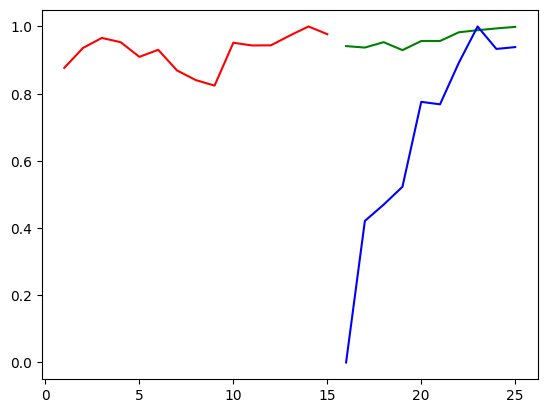

In [137]:
# print(last_days)
# print(y_test[:-time_step])
pred_days = 10
last_days, day_pred, lst_output = predict(pred_days, svr)

next_begin = end_date + datetime.timedelta(days=1)
next_end = next_begin + datetime.timedelta(days=pred_days*2)

next_days = get_data(stock_name, start_date=f'{next_begin.day}/{next_begin.month}/{next_begin.year}', end_date=f'{next_end.day}/{next_end.month}/{next_end.year}', index_as_date = True, interval="1d").to_numpy()
next_stock = next_days[:pred_days, 4]

# last = scaler.inverse_transform(y_test[-time_step:].reshape(-1, 1))
# next = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
last = y_test[-time_step:]
next = lst_output
next_stock = scaler.fit_transform(next_stock.reshape(-1, 1))

plt.plot(last_days, last, "r")
plt.plot(day_pred, next, "g")
plt.plot(day_pred, next_stock, "b")
plt.show()

In [138]:
next_few_days_pred = ["buy" if next[i] < next[i+1] else "sell" for i in range(pred_days-1)]
next_few_days_pred = ["buy" if last[-1] < next[0] else "sell"] + next_few_days_pred

nfd_real = ["buy" if next_stock[i] < next_stock[i+1] else "sell" for i in range(pred_days-1)]
nfd_real = ["buy" if y_test[-1] < next_stock[0] else "sell"] + nfd_real

for i in range(len(nfd_real)):
  print("Day:", i+1, " "*(10-len(str(i+1))) + "Pred:", next_few_days_pred[i], "\tReal:", nfd_real[i], "\t", next_few_days_pred[i]==nfd_real[i] )

Day: 1          Pred: sell 	Real: sell 	 True
Day: 2          Pred: sell 	Real: buy 	 False
Day: 3          Pred: buy 	Real: buy 	 True
Day: 4          Pred: sell 	Real: buy 	 False
Day: 5          Pred: buy 	Real: buy 	 True
Day: 6          Pred: buy 	Real: sell 	 False
Day: 7          Pred: buy 	Real: buy 	 True
Day: 8          Pred: buy 	Real: buy 	 True
Day: 9          Pred: buy 	Real: sell 	 False
Day: 10         Pred: buy 	Real: buy 	 True


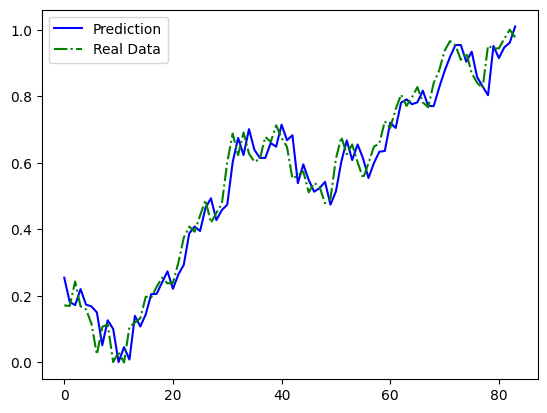

In [139]:
from sklearn.linear_model import LinearRegression 

lr = LinearRegression().fit(X_train, y_train)
# print(lr.score(X_test, y_test))

pred = lr.predict(X_test)
x = [i for i in range(pred.shape[0])]
plt.plot(x, pred, "b")
plt.plot(x, y_test, "g-.")
plt.legend(["Prediction", "Real Data"])
plt.show()

/usr/local/lib/python3.9/dist-packages/yahoo_fin/stock_info.py:29: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  end_seconds = int(pd.Timestamp(end_date).timestamp())


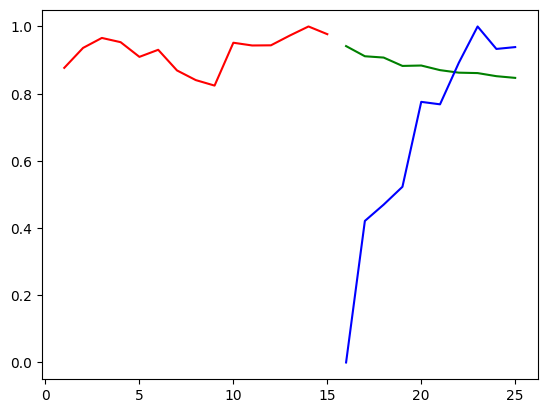

In [140]:
pred_days = 10
last_days, day_pred, lst_output = predict(pred_days, lr)

# next_begin = end_date + datetime.timedelta(day=1)
# next_end = next_begin + datetime.timedelta(day=pred_days)

next_days = get_data(stock_name, start_date=f'{next_begin.day}/{next_begin.month}/{next_begin.year}', end_date=f'{next_end.day}/{next_end.month}/{next_end.year}', index_as_date = True, interval="1d").to_numpy()
next_stock = next_days[:pred_days, 4]

# last = scaler.inverse_transform(y_test[-time_step:].reshape(-1, 1))
# next = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
last = y_test[-time_step:]
next = lst_output
next_stock = scaler.fit_transform(next_stock.reshape(-1, 1))

plt.plot(last_days, last, "r")
plt.plot(day_pred, next, "g")
plt.plot(day_pred, next_stock, "b")
plt.show()

In [141]:
next_few_days_pred = ["buy" if next[i] < next[i+1] else "sell" for i in range(pred_days-1)]
next_few_days_pred = ["buy" if last[-1] < next[0] else "sell"] + next_few_days_pred

nfd_real = ["buy" if next_stock[i] < next_stock[i+1] else "sell" for i in range(pred_days-1)]
nfd_real = ["buy" if y_test[-1] < next_stock[0] else "sell"] + nfd_real

for i in range(len(nfd_real)):
  print("Day:", i+1, " "*(10-len(str(i+1))) + "Pred:", next_few_days_pred[i], "\tReal:", nfd_real[i], "\t", next_few_days_pred[i]==nfd_real[i] )


Day: 1          Pred: sell 	Real: sell 	 True
Day: 2          Pred: sell 	Real: buy 	 False
Day: 3          Pred: sell 	Real: buy 	 False
Day: 4          Pred: sell 	Real: buy 	 False
Day: 5          Pred: buy 	Real: buy 	 True
Day: 6          Pred: sell 	Real: sell 	 True
Day: 7          Pred: sell 	Real: buy 	 False
Day: 8          Pred: sell 	Real: buy 	 False
Day: 9          Pred: sell 	Real: sell 	 True
Day: 10         Pred: sell 	Real: buy 	 False
